In [1]:
pip install pandas matplotlib seaborn


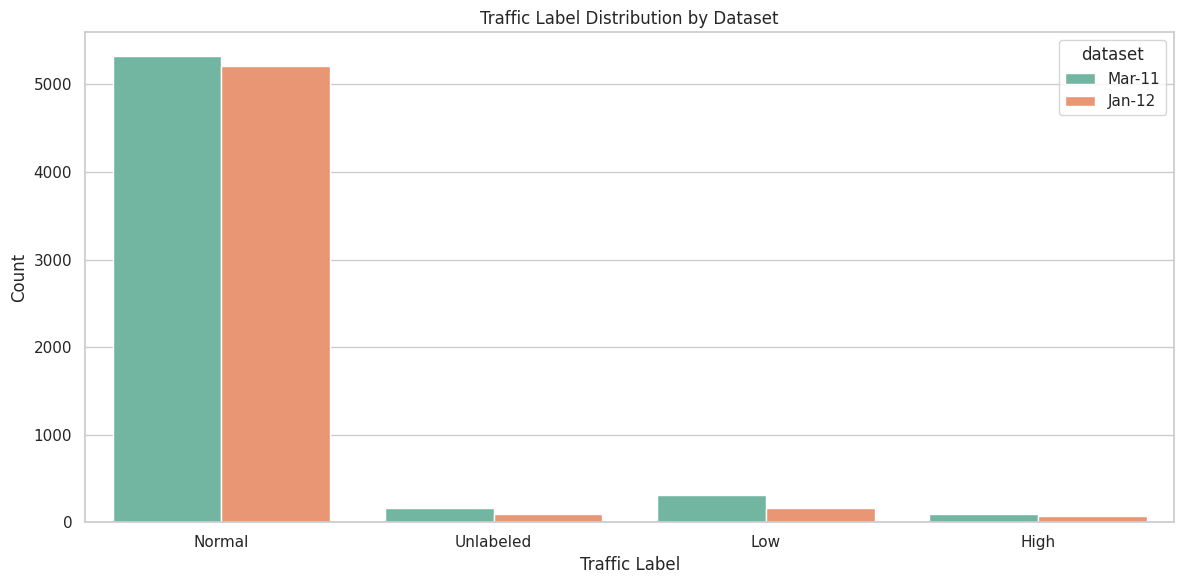

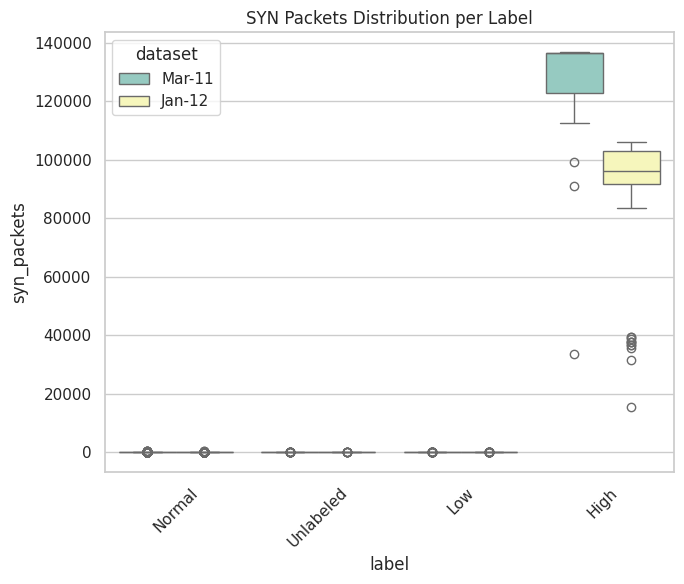

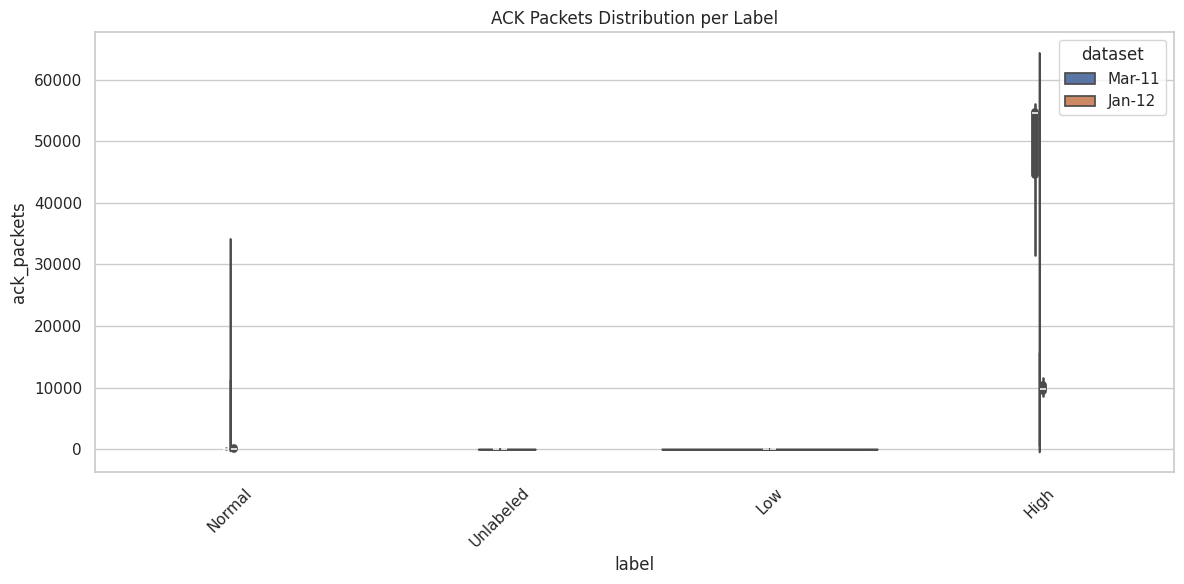

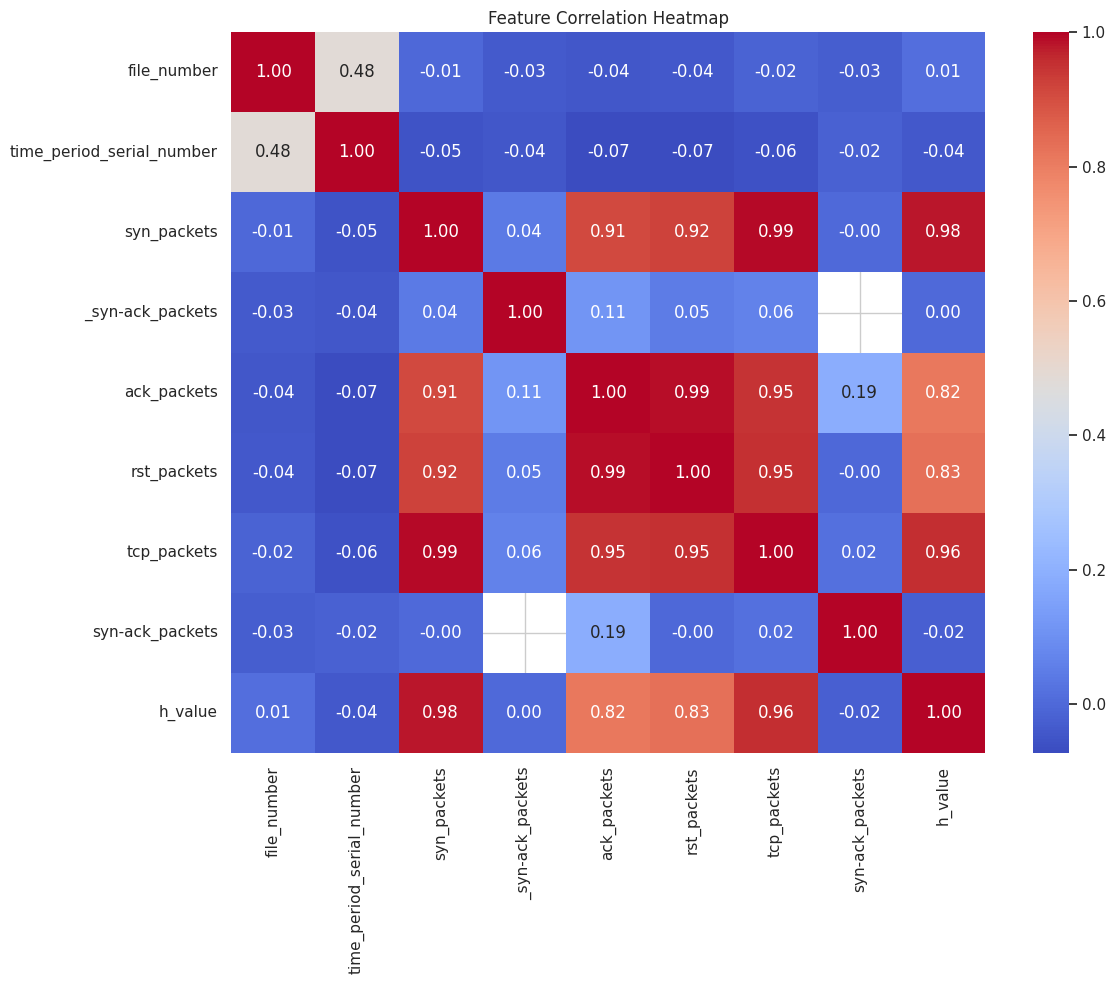

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Download files from Google Drive
mar_url = "https://drive.google.com/uc?id=1DuT5XWwYLaJIUE94fCg8N1fHo7GjPNbl"
jan_url = "https://drive.google.com/uc?id=1sbgZjma8h5VCDTGKhzjIYNGGIV8scnuq"

# Load datasets directly
mar_data = pd.read_csv(mar_url)
jan_data = pd.read_csv(jan_url)

# Clean column names
mar_data.columns = mar_data.columns.str.strip().str.lower().str.replace('#', '').str.replace(' ', '_')
jan_data.columns = jan_data.columns.str.strip().str.lower().str.replace('#', '').str.replace(' ', '_')

# Add dataset identifiers
mar_data['dataset'] = 'Mar-11'
jan_data['dataset'] = 'Jan-12'



# Combine datasets
combined_data = pd.concat([mar_data, jan_data], ignore_index=True)

# Compute H value: SYN - ACK
combined_data['h_value'] = combined_data['syn_packets'] - combined_data['ack_packets']

# Labeling logic based on H
def assign_label(h):
    if h < 0:
        return 'Normal'
    elif 0 < h < 30:
        return 'Low'
    elif 30 <= h < 70:
        return 'Moderate'
    elif h >= 70:
        return 'High'
    else:
        return 'Unlabeled'

combined_data['label'] = combined_data['h_value'].apply(assign_label)

# === Visualizations ===
sns.set(style="whitegrid")

# Label distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=combined_data, x='label', hue='dataset', palette='Set2')
plt.title('Traffic Label Distribution by Dataset')
plt.xlabel('Traffic Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# SYN Packets Boxplot
plt.figure(figsize=(7,6))
sns.boxplot(data=combined_data, x='label', y='syn_packets', hue='dataset', palette='Set3')
plt.title('SYN Packets Distribution per Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ACK Packets Violin Plot
plt.figure(figsize=(12, 6))
sns.violinplot(data=combined_data, x='label', y='ack_packets', hue='dataset', split=True)
plt.title('ACK Packets Distribution per Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(combined_data.drop(columns=['dataset', 'label']).corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()


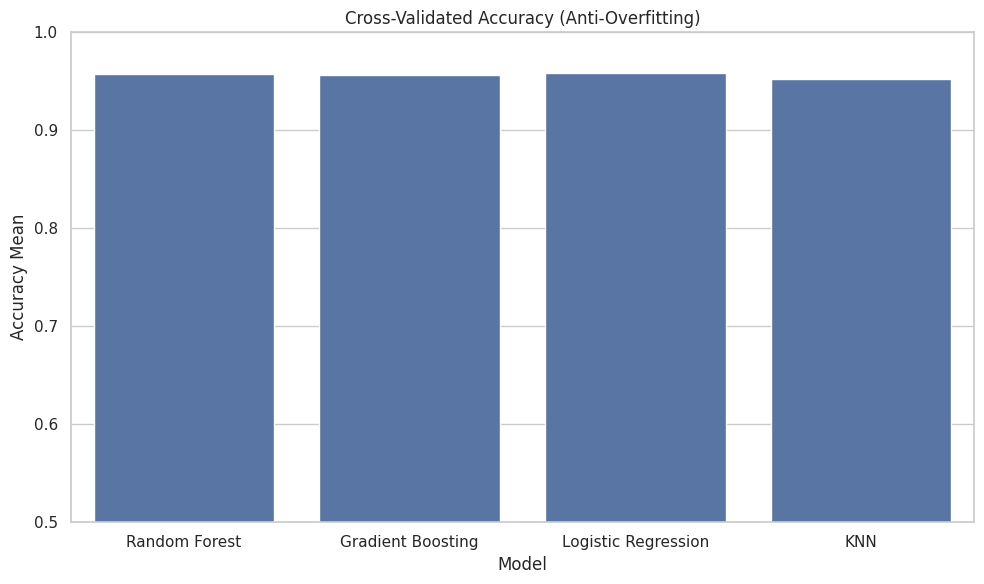

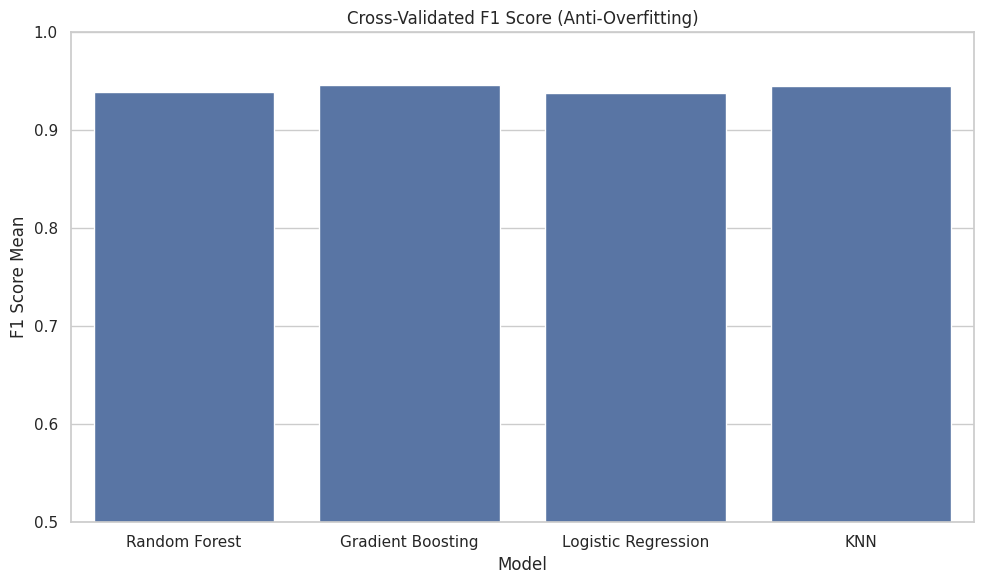

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load data from Google Drive
mar_url = "https://drive.google.com/uc?id=1DuT5XWwYLaJIUE94fCg8N1fHo7GjPNbl"
jan_url = "https://drive.google.com/uc?id=1sbgZjma8h5VCDTGKhzjIYNGGIV8scnuq"
mar_data = pd.read_csv(mar_url)
jan_data = pd.read_csv(jan_url)

# 2. Clean column names
for df in [mar_data, jan_data]:
    df.columns = df.columns.str.strip().str.lower().str.replace('#', '').str.replace(' ', '_')
mar_data['dataset'] = 'Mar-11'
jan_data['dataset'] = 'Jan-12'
combined_data = pd.concat([mar_data, jan_data], ignore_index=True)

# 3. Add label from business logic
combined_data['h_value'] = combined_data['syn_packets'] - combined_data['ack_packets']
def assign_label(h):
    if h < 0: return 'Normal'
    elif 0 < h < 30: return 'Low'
    elif 30 <= h < 70: return 'Moderate'
    elif h >= 70: return 'High'
    else: return 'Unlabeled'
combined_data['label'] = combined_data['h_value'].apply(assign_label)
combined_data = combined_data[combined_data['label'] != 'Unlabeled']

# 4. Drop features that cause leakage
combined_data = combined_data.drop(columns=['syn_packets', 'ack_packets', 'h_value'])

# 5. Encode label and add noise
label_map = {'Normal': 0, 'Low': 1, 'Moderate': 2, 'High': 3}
combined_data['label_encoded'] = combined_data['label'].map(label_map)

# Inject noise to simulate imperfect conditions
for col in ['rst_packets', 'tcp_packets']:
    combined_data[col] += np.random.randint(-3, 4, size=combined_data.shape[0])

# 6. Split features and target
X = combined_data[['rst_packets', 'tcp_packets']]
y = combined_data['label_encoded']

# 7. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 8. Define models (XGBoost added)
models = {
    'Random Forest': RandomForestClassifier(max_depth=5, n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(max_depth=3, n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, C=0.5, penalty='l2'),
    'KNN': KNeighborsClassifier(n_neighbors=5),
}

# 9. Cross-validation and scoring
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for name, model in models.items():
    acc_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring=make_scorer(accuracy_score))
    f1_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring=make_scorer(f1_score, average='weighted'))
    results.append({
        'Model': name,
        'Accuracy Mean': acc_scores.mean(),
        'F1 Score Mean': f1_scores.mean()
    })

results_df = pd.DataFrame(results)

# 10. Plot results
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Model', y='Accuracy Mean')
plt.title('Cross-Validated Accuracy (Anti-Overfitting)')
plt.ylim(0.5, 1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Model', y='F1 Score Mean')
plt.title('Cross-Validated F1 Score (Anti-Overfitting)')
plt.ylim(0.5, 1)
plt.tight_layout()
plt.show()


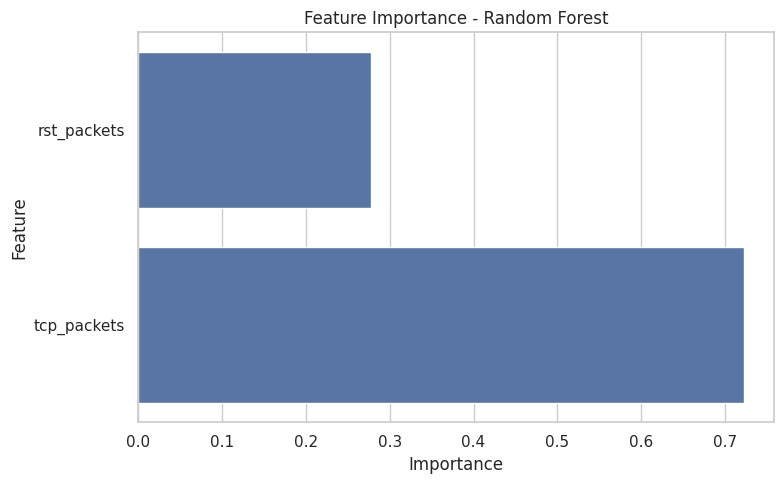

In [5]:
# Visualize Feature Importance (as a SHAP alternative)
# Fit the Random Forest model separately to get feature importances
rf_model = models['Random Forest']
rf_model.fit(X_scaled, y)

importances = rf_model.feature_importances_
features = X.columns

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [ ]:
# results of models
results_df

,Model,Accuracy Mean,F1 Score Mean
0,Random Forest,0.958117,0.937674
1,Gradient Boosting,0.955701,0.940794
2,Logistic Regression,0.958028,0.937586
3,KNN,0.951584,0.945761


In [ ]:
combined_data

,file_number,time_period_serial_number,syn_packets,_syn-ack_packets,ack_packets,rst_packets,tcp_packets,dataset,syn-ack_packets,h_value,label
0,1,1,0,0.0,43,0,43,Mar-11,NaN,-43,Normal
1,1,2,0,0.0,1,0,1,Mar-11,NaN,-1,Normal
2,1,3,1,0.0,48,6,55,Mar-11,NaN,-47,Normal
3,1,4,3,0.0,27,8,36,Mar-11,NaN,-24,Normal
4,1,5,5,0.0,13,4,20,Mar-11,NaN,-8,Normal
...,...,...,...,...,...,...,...,...,...,...,...
11418,818,5527,36516,NaN,5817,3763,46100,Jan-12,4.0,30699,High
11419,818,5528,39516,NaN,1817,1763,43129,Jan-12,33.0,37699,High
11420,818,5529,31516,NaN,2897,2763,37181,Jan-12,5.0,28619,High
11421,818,5530,37516,NaN,3817,4763,46108,Jan-12,12.0,33699,High


In [ ]:
# to dowload data
from google.colab import files
combined_data.to_csv('filename.csv', index=False)

files.download('filename.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>